In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Filenames and directories
MODULE_DIR = "other_prediction_functions"
INPUT_SQ_DIR = "a. Input time series sequences"

folders = {
    "dev_folders": [
        "2. sq sl010 sag Xcs=125 3 cpts 2024 normalised",
        "3. sq sl010 sag Xcs=80 3 cpts 2024 normalised",
        "4. sq sl014 sag Xcs=165 3 cpts 2024 normalised",
        "5. sq sl014 sag Xcs=95 3 cpts 2024 normalised",
    ],
    "test_folders": [
        "2020-11-10_KS81_Nav_Pur_1_3_cpts",
        "2020-11-12_QN76_Nav_Pur_1_3_cpts",
        "2020-11-17_CS31_Nav_Pur_2_3_cpts",
        "2020-11-17_JY02_Nav_Pur_2_3_cpts",
        "2020-11-23_ON65_Nav_Pur_2_3_cpts",
        "2020-11-23_PS11_Nav_Pur_1_3_cpts",
        "2020-11-25_II29_Nav_Pur_1_3_cpts",
        "2020-11-26_NE38_Nav_Pur_1_3_cpts",
    ],
}

# Resampling parameters
dev_freq_hz = 3.18
test_freq_hz = 6.0

horizon = 12

# Hyperparameters
seq_length = 24  # Input sequence length
training_fraction = 0.8  # Fraction of data used for training

In [3]:
import sys
import os

# Get the current notebook's directory
notebook_dir = os.getcwd()

# Construct the relative path to the module
module_dir = os.path.join(notebook_dir, "..", MODULE_DIR)

# Add to sys.path if not already included
if module_dir not in sys.path:
    sys.path.append(module_dir)

# Importing the module for transformer forecasting
import transformers_forecasting as tf  # type: ignore

Loading the data


In [4]:
# Loading data
workspace_dir = os.path.dirname(notebook_dir)
for folder_type, folders_list in folders.items():
    folders[folder_type] = [os.path.join(workspace_dir, INPUT_SQ_DIR, folder) for folder in folders_list]

raw_data, n_features = tf.load_dev_test_data(**folders)

Loading development data from /home/mpohl/dev/2D-MR-image-prediction/Time_series_forecasting/a. Input time series sequences/2. sq sl010 sag Xcs=125 3 cpts 2024 normalised...
Loading development data from /home/mpohl/dev/2D-MR-image-prediction/Time_series_forecasting/a. Input time series sequences/3. sq sl010 sag Xcs=80 3 cpts 2024 normalised...
Loading development data from /home/mpohl/dev/2D-MR-image-prediction/Time_series_forecasting/a. Input time series sequences/4. sq sl014 sag Xcs=165 3 cpts 2024 normalised...
Loading development data from /home/mpohl/dev/2D-MR-image-prediction/Time_series_forecasting/a. Input time series sequences/5. sq sl014 sag Xcs=95 3 cpts 2024 normalised...
Loading test data from /home/mpohl/dev/2D-MR-image-prediction/Time_series_forecasting/a. Input time series sequences/2020-11-10_KS81_Nav_Pur_1_3_cpts...
Loading test data from /home/mpohl/dev/2D-MR-image-prediction/Time_series_forecasting/a. Input time series sequences/2020-11-12_QN76_Nav_Pur_1_3_cpts...


In [5]:
raw_data.keys()

dict_keys(['dev_data', 'dev_metadata', 'test_data', 'test_metadata'])

In [6]:
raw_data["dev_data"][0].shape

(3, 200)

In [7]:
n_features

3

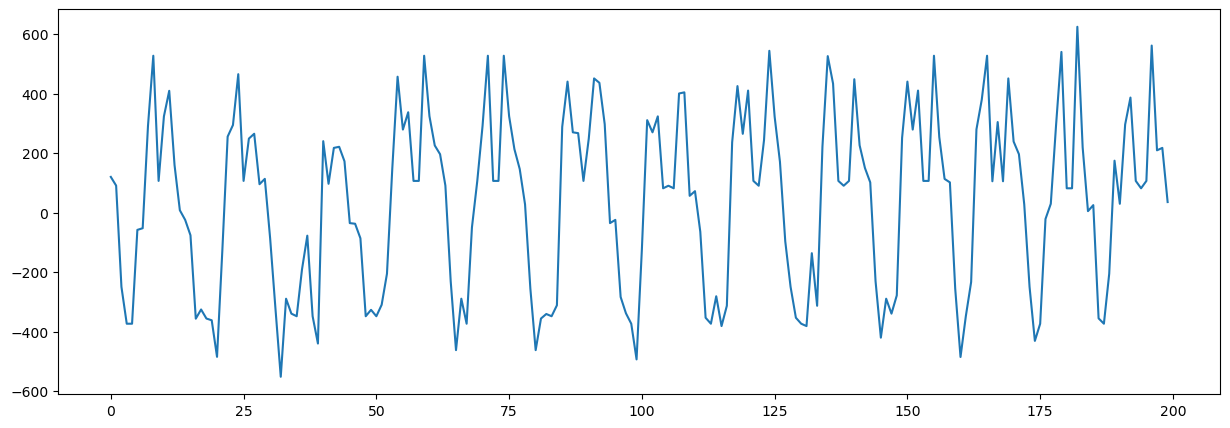

In [8]:
# plotting the original data - modify the sequence index and coordinate you want to plot
sequence_idx = 0
crd_idx = 1

plt.figure(figsize=(15, 5))
plt.plot(raw_data["dev_data"][sequence_idx][crd_idx].T)
plt.show()

Resampling the data


In [9]:
# Resample data if frequencies differ
if dev_freq_hz != test_freq_hz:
    resampled_dev_data = tf.resample_data_poly(raw_data["dev_data"], dev_freq_hz, test_freq_hz)

resampled_data = raw_data.copy()
resampled_data["dev_data"] = resampled_dev_data

Resampling with ratio 3.18/6.0 = 53/100
Resampled dev signal 1: 200 → 378 samples (expected ~377)
Resampled dev signal 2: 200 → 378 samples (expected ~377)
Resampled dev signal 3: 200 → 378 samples (expected ~377)
Resampled dev signal 4: 200 → 378 samples (expected ~377)


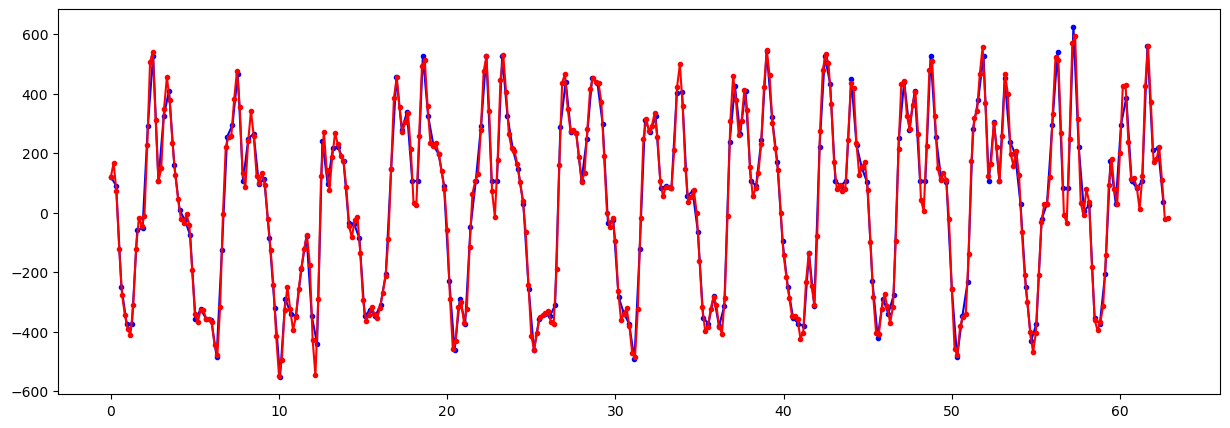

In [10]:
# plotting the original against the resampled data to check that resampling worked
org_sq = raw_data["dev_data"][sequence_idx][crd_idx].T
resampled_sq = resampled_dev_data[sequence_idx][crd_idx].T

# plot inspired by https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample_poly.html
t = np.linspace(0, (1 / dev_freq_hz) * org_sq.shape[0], org_sq.shape[0], endpoint=False)
t_new = np.linspace(0, (1 / test_freq_hz) * resampled_sq.shape[0], resampled_sq.shape[0], endpoint=False)

plt.figure(figsize=(15, 5))
plt.plot(
    t, raw_data["dev_data"][sequence_idx][crd_idx].T, "b.-", t_new, resampled_dev_data[sequence_idx][crd_idx].T, "r.-"
)
plt.show()

In [12]:
# Preprocessing data and splitting the data into pairs of unput and target values
standardized_data = tf.preprocess_data(resampled_data, horizon, seq_length, training_fraction)

train set: Added 267 sequences
train set: Added 267 sequences
train set: Added 267 sequences
train set: Added 267 sequences
val set: Added 41 sequences
val set: Added 41 sequences
val set: Added 41 sequences
val set: Added 41 sequences
test set: Added 463 sequences
test set: Added 463 sequences
test set: Added 463 sequences
test set: Added 463 sequences
test set: Added 463 sequences
test set: Added 463 sequences
test set: Added 463 sequences
test set: Added 463 sequences
